## Abstract

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world. We are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

In this notebook I am using TensorFlow and Long-short Term Memory Recurrent Neural Network (LSTM RNN) to predict bike sharing demand by varying Network architecture, Activation function, Cost function, Epochs, Gradient estimation and Network initialization.

In [669]:
import pandas as pd
import matplotlib.pyplot as plt
import utils as utl
#%matplotlib inline
import numpy as np
from sklearn.metrics import mean_absolute_error
from IPython.display import Image

In [933]:
df = pd.read_csv("bikesharing_train.csv", parse_dates=["datetime"])

## Data Fields

datetime - hourly date + timestamp 

season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

In [934]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Converting 'datetime' field to  integer

In [935]:
df['datetime'] = pd.to_datetime(df['datetime'], '%d/%m/%Y').dt.strftime('%Y%m%d').astype(int)

In [936]:
data = df.dropna()
data = data.drop(data.columns[[1, 2, 3, 4, 5, 9, 10]], axis= 1)

In [937]:
data

,datetime,atemp,humidity,windspeed,count
0,20110101,14.395,81,0.0000,16
1,20110101,13.635,80,0.0000,40
2,20110101,13.635,80,0.0000,32
3,20110101,14.395,75,0.0000,13
4,20110101,14.395,75,0.0000,1
5,20110101,12.880,75,6.0032,1
6,20110101,13.635,80,0.0000,2
7,20110101,12.880,86,0.0000,3
8,20110101,14.395,75,0.0000,8
9,20110101,17.425,76,0.0000,14


In [938]:
x_data = data.drop(data.columns[-1], axis= 1)

In [939]:
y_data = data.drop(data.columns[[0, 1, 2, 3]], axis= 1)

In [940]:
x_data = x_data.values

In [941]:
y_data = y_data.values

## Definitions

We will predict count of bikes demanded for the next 90 days in the given dataset.

In [942]:
periods = 90 # days

## Train Data

In [943]:
train_x = x_data[0:(len(df) - (len(df) % periods))]

train_x_batches = train_x.reshape(-1, periods, 4)  
# Uses 4 because it has four independent feature
# created 120 batches with 90 records with 1 feature

# Using count for the "next day" of each 90 days batch as the dependent variable.
train_y = y_data[1:(len(data) - (len(data) % periods)) + 1] # increment 1 to get the "next day"
train_y_batches = train_y.reshape(-1, periods, 1)

print('train_x shape: ', train_x.shape)
print('train_y shape: ', train_y.shape)

print('train_x_batches shape: ', train_x_batches.shape)
print('train_y_batches shape: ', train_y_batches.shape)

train_x shape:  (10800, 4)
train_y shape:  (10800, 1)
train_x_batches shape:  (120, 90, 4)
train_y_batches shape:  (120, 90, 1)


## Test Data

Here we will be using bike sharing data of latest 90 days to evaluate the accuracy.

In [944]:
test_x = x_data[-(periods + 1):]
test_x = test_x[:periods]
test_x = test_x.reshape(-1, periods, 4)
print('test_x shape: ', test_x.shape)

test_y = y_data[-(periods):]
test_y = test_y.reshape(-1, periods, 1)
print('test_y shape: ', test_y.shape)

test_x shape:  (1, 90, 4)
test_y shape:  (1, 90, 1)


## Implementing Tensorflow

In [1059]:
import tensorflow as tf
tf.reset_default_graph() # memory clean

## Part A - Deep Learning Model

## Neural Network definitions

## What is an RNN?
It is short for “Recurrent Neural Network”, and is basically a neural network that can be used when your data is treated as a sequence, where the particular order of the data-points matter. More importantly, this sequence can be of arbitrary length.

The most straight-forward example is perhaps a time-seriedems of numbers, where the task is to predict the next value given previous values. The input to the RNN at every time-step is the current value as well as a state vector which represent what the network has “seen” at time-steps before. This state-vector is the encoded memory of the RNN, initially set to zero.

In [988]:
Image(url= "https://analyticsindiamag.com/wp-content/uploads/2018/01/nural-network-03.jpg")

In [989]:
# We will set up a function to build the LSTM Layers to dynamically handle the number of layers and activation function.
def create_cell(neurons_hidden, activation, initializer):
    return tf.contrib.rnn.LSTMCell(num_units = neurons_hidden, activation = activation, initializer= initializer)

In [990]:
# The below function will stack up multiple LSTM layers, for deep learning
def create_cells(neurons_hidden, layers, keep_prob, activation, initializer):
    cells = tf.nn.rnn_cell.MultiRNNCell([create_cell(neurons_hidden, activation, initializer) for i in range(layers)]) # hidden layers
    dropout_layers = tf.contrib.rnn.DropoutWrapper(cells, output_keep_prob= keep_prob)
    return dropout_layers

In [991]:
def lstm_model(neurons_hidden, layers, activation, initializer, optimizer):
    neurons_input = 4 # four independent variable (feature)
    neurons_output = 1 #  one dependent variable
    
# Here the inputs (xph) and targets (yph) have placeholders of dimensions [None, periods, neurons_input]. 
# We use None because at this time we don’t know how long our sequence will be — it will be determined during the runtime.
    xph = tf.placeholder(tf.float32, [None, periods, neurons_input])
    yph = tf.placeholder(tf.float32, [None, periods, neurons_output])

    cell = create_cells(neurons_hidden, layers, 0.3, activation, initializer) # hidden layers = 4, 20% dropout

# At each time step we now have an output vector of size 3. But what we actually want is a single output value at each time step.
# The simplest solution is to wrap the cell in an OutputProjectionWrapper
    cell_output = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size=1) # Dense Neural Network

    rnn_output, _ = tf.nn.dynamic_rnn(cell_output, xph, dtype=tf.float32)

# Now we need to define the cost function. We will first use the Mean Squared Error (MSE). 
# The predictions are fed to our mean squared error loss function.

    error_mse = tf.losses.mean_squared_error(labels=yph, predictions=rnn_output)
    
    #Hinge Loss
    error_hingeLoss = tf.losses.hinge_loss(labels=yph, logits = rnn_output)
    error_dict = {'MSE' : error_mse,
                 'HingeLoss' : error_hingeLoss}

# Next we will create an Adam optimizer and use it to minimize the loss.

    optimizer = optimizer

    train_mse = optimizer.minimize(error_mse)
    train_hingeLoss = optimizer.minimize(error_hingeLoss)
    train_dict = {'MSE' : train_mse,
                 'HingeLoss' : train_hingeLoss}
    return xph, yph, rnn_output, error_dict, train_dict

In [950]:
def lstm_execute(error, train, epochs):
    with tf.Session() as s:
#Only after running tf.global_variables_initializer() in a session will our variables hold the values we tell them to hold when we declare them
        s.run(tf.global_variables_initializer())
        for epoch in range(epochs):
            # compute the loss for an epoch, which is usually defined as the average of the loss of batches in that epoch
            _, cost = s.run([train, error], feed_dict = { xph: train_x_batches, yph: train_y_batches })
            
            if epoch % 100 == 0:
                
                print ("Cost for the training cycle : ",epoch," : is : ",s.run(error, feed_dict ={xph :train_x_batches, yph:train_y_batches}))

        pred = s.run(rnn_output, feed_dict = {xph: test_x })

    return pred

## Part B - Activation function

### 1. Softplus

In [1022]:
xph, yph, rnn_output, error_dict , train_dict = lstm_model(3, 5, tf.nn.softplus, tf.contrib.layers.xavier_initializer(), tf.train.RMSPropOptimizer(learning_rate=0.001))

It can be inferred that when using activation function= Softplus, the network plateaus after 600 epochs (approx.).

In [1023]:
pred = lstm_execute(error_dict['MSE'], train_dict['MSE'], 700)

Cost for the training cycle :  0  : is :  69784.83
Cost for the training cycle :  100  : is :  69110.945
Cost for the training cycle :  200  : is :  64026.016
Cost for the training cycle :  300  : is :  60634.98
Cost for the training cycle :  400  : is :  59779.414
Cost for the training cycle :  500  : is :  59612.06
Cost for the training cycle :  600  : is :  59187.39


## Accuracy

We didn't get decent result using  LSTM function, Activation function = Softplus, Cost function = Adam Optimizer, Network architecture and Dropout technique for this dataset.

In [1024]:
# function to calculate accuracy and plot the graph.
def accuracy():
    check_y = np.ravel(test_y)
    check_predictions = np.ravel(pred)
    mae = mean_absolute_error(check_y, check_predictions)
    plt.plot(check_y, '*', markersize=10, label = 'Real value')
    plt.plot(check_predictions, 'o', markersize=10, label = 'Predictions')
    plt.legend()
    plt.plot(check_y, label = 'Real value')
    plt.plot(check_predictions, label = 'Predictions')
    plt.legend()
    return mae

178.39599548776945

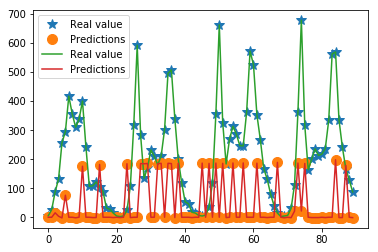

In [1025]:
accuracy()

## 2. Leaky ReLU

In [1051]:
tf.reset_default_graph() # memory clean

In [1012]:
xph, yph, rnn_output, error_dict , train_dict = lstm_model(3, 5, tf.nn.leaky_relu, tf.contrib.layers.xavier_initializer(), tf.train.RMSPropOptimizer(learning_rate=0.001))

It can be inferred that when using activation function= Leaky ReLU, the network plateaus after 600 epochs (approx.).

In [1013]:
pred = lstm_execute(error_dict['MSE'], train_dict['MSE'], 600)

Cost for the training cycle :  0  : is :  69466.67
Cost for the training cycle :  100  : is :  69409.91
Cost for the training cycle :  200  : is :  64863.836
Cost for the training cycle :  300  : is :  54651.84
Cost for the training cycle :  400  : is :  52192.977
Cost for the training cycle :  500  : is :  51570.33


## Accuracy

We didn't get decent result using  LSTM function, Activation function = Leaky ReLU, Cost function = Adam Optimizer, Network architecture and Dropout technique for this dataset.

192.16571128633288

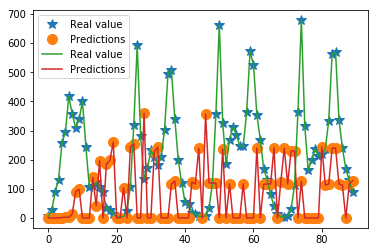

In [1015]:
accuracy()

## Part C - Cost function

### 1. Hinge Loss

In [1046]:
xph, yph, rnn_output, error_dict , train_dict = lstm_model(3, 5, tf.nn.leaky_relu, tf.contrib.layers.xavier_initializer(), tf.train.RMSPropOptimizer(learning_rate=0.001))

In [1043]:
pred = lstm_execute(error_dict['HingeLoss'], train_dict['HingeLoss'], 600)

Cost for the training cycle :  0  : is :  0.273825
Cost for the training cycle :  100  : is :  0.048395306
Cost for the training cycle :  200  : is :  0.014433331
Cost for the training cycle :  300  : is :  0.0069778804
Cost for the training cycle :  400  : is :  0.003908948
Cost for the training cycle :  500  : is :  0.0029398259


208.4352059543133

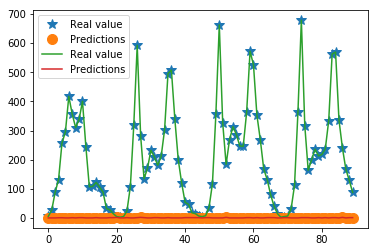

In [1044]:
accuracy()

## Part D - Epochs

In [1052]:
xph, yph, rnn_output, error_dict , train_dict = lstm_model(3, 5, tf.nn.leaky_relu, tf.contrib.layers.xavier_initializer(), tf.train.RMSPropOptimizer(learning_rate=0.009))

It can be inferred that network plateaus after 800 epochs.

In [1053]:
pred = lstm_execute(error_dict['MSE'], train_dict['MSE'], 800)

Cost for the training cycle :  0  : is :  69448.76
Cost for the training cycle :  100  : is :  69124.766
Cost for the training cycle :  200  : is :  68882.56
Cost for the training cycle :  300  : is :  68465.2
Cost for the training cycle :  400  : is :  68036.26
Cost for the training cycle :  500  : is :  58101.066
Cost for the training cycle :  600  : is :  57818.902
Cost for the training cycle :  700  : is :  56984.883


182.5451501528422

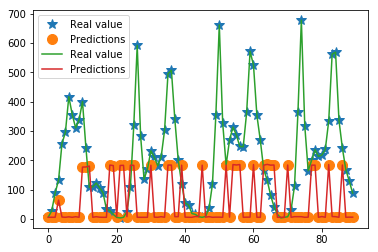

In [1054]:
accuracy()

## Part E - Gradient estimation

## 1. Adadelta

In [1060]:
xph, yph, rnn_output, error_dict , train_dict = lstm_model(3, 5, tf.nn.leaky_relu, tf.contrib.layers.xavier_initializer(), tf.train.AdadeltaOptimizer(learning_rate=0.001))

It can be inferred that network plateaus after 100 epochs.

In [1061]:
pred = lstm_execute(error_dict['MSE'], train_dict['MSE'], 800)

Cost for the training cycle :  0  : is :  69467.67
Cost for the training cycle :  100  : is :  69467.65
Cost for the training cycle :  200  : is :  69467.65
Cost for the training cycle :  300  : is :  69467.64
Cost for the training cycle :  400  : is :  69467.63
Cost for the training cycle :  500  : is :  69467.62
Cost for the training cycle :  600  : is :  69467.6
Cost for the training cycle :  700  : is :  69467.59


209.37719351281476

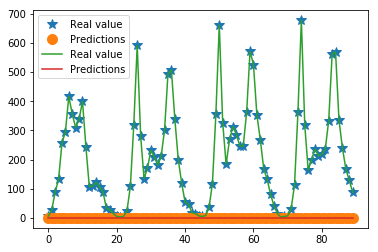

In [1062]:
accuracy()

## Part F - Network Architecture

### 1. Changing the number of layers

In [573]:
xph, yph, rnn_output, error_dict , train_dict = lstm_model(3, 7, tf.nn.leaky_relu, tf.contrib.layers.xavier_initializer(), tf.train.AdagradDAOptimizer(learning_rate=0.001, global_step=tf.train.create_global_step()))

It can be inferred that when using Network layers = 7, the network plateaus after 100 epochs (approx.).

In [574]:
pred = lstm_execute(error_dict['MSE'], train_dict['MSE'], 600)

Cost for the training cycle :  0  : is :  69467.47
Cost for the training cycle :  100  : is :  69464.06
Cost for the training cycle :  200  : is :  69462.49
Cost for the training cycle :  300  : is :  69461.29
Cost for the training cycle :  400  : is :  69460.26
Cost for the training cycle :  500  : is :  69459.375


209.3532827353312

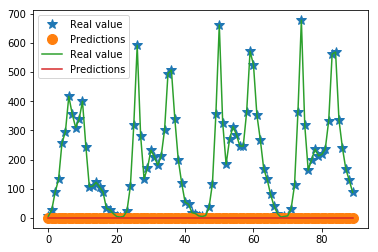

In [575]:
accuracy()

### 2. Changing the number of hidden neurons

In [679]:
# hidden neurons = 4
xph, yph, rnn_output, error_dict , train_dict = lstm_model(4, 5, tf.nn.leaky_relu, tf.contrib.layers.xavier_initializer(), tf.train.RMSPropOptimizer(learning_rate=0.001))

It can be inferred that network does not plateaus after 600 epochs.

In [680]:
pred = lstm_execute(error_dict['MSE'], train_dict['MSE'], 600)

Cost for the training cycle :  0  : is :  69450.44
Cost for the training cycle :  100  : is :  66467.37
Cost for the training cycle :  200  : is :  64662.13
Cost for the training cycle :  300  : is :  60308.45
Cost for the training cycle :  400  : is :  57253.145
Cost for the training cycle :  500  : is :  53825.688


172.30493488974042

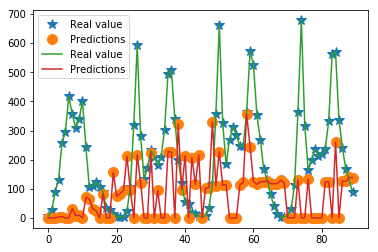

In [681]:
accuracy()

## Part G - Network initialization

### 1. Orthogonal Initializer

In [653]:
xph, yph, rnn_output, error_dict , train_dict = lstm_model(3, 5, tf.nn.leaky_relu, tf.orthogonal_initializer, tf.train.RMSPropOptimizer(learning_rate=0.001))

It can be inferred that when using Network Initializer = Orthogonal initializer, the network plateaus after 600 epochs (approx.).

In [654]:
pred = lstm_execute(error_dict['MSE'], train_dict['MSE'], 600)

Cost for the training cycle :  0  : is :  69462.305
Cost for the training cycle :  100  : is :  67977.375
Cost for the training cycle :  200  : is :  67240.875
Cost for the training cycle :  300  : is :  66956.38
Cost for the training cycle :  400  : is :  66772.29
Cost for the training cycle :  500  : is :  66332.56


201.5714698718654

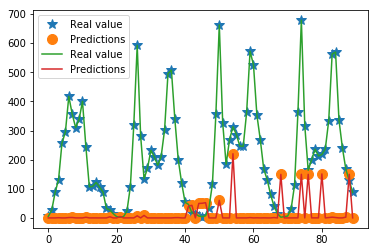

In [655]:
accuracy()

## Contribution Statement

o Using TensorFlow and Long-short Term Memory Recurrent Neural Network (LSTM RNN) to predict bike sharing demand.

o Implemented different Activation functions, Cost functions, Hidden layers, Hidden neurons, Gradient estimation, number of epochs, Network initialization to improve the model accuracy.

## Conclusion

In this notebook, we have tried Long-short Term Memory Recurrent Neural Network (LSTM RNN) to predict bike sharing demand in Washington DC. We have tried to improve the accuracy of our deep learning model by changing activation functions like Leaky rectified linear unit (Leaky ReLU) and SoftPlus, cost functions like Quadratic cost (mean-square error) and HingeLoss, number of epochs, Gradient estimation like ADAM and AdaDelta, network architecture like number of layers and number of hidden neurons and Network initialization like Xavier and Orthognal initializer.

We got our best accuracy by using Activation function = Leaky ReLU, Cost funtion = Quadratic cost (mean-square error), Gradient estimation = RMSProp, epochs = 600, hidden neurons = 3, layers = 5 and Network initialization = Xavier Uniform.

## Citations

o https://www.kaggle.com/rafaelleonhardt/tensorflow-predict-stock-prices-with-lstm-rnn/data

o https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

## Licence

MIT License

Copyright (c) 2018 Kamran Ahmad

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.